In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False 
######## 读取数据 ########
sheet = pd.read_excel('data_input_auto/山东柴油裂解差Trend-F=0.2.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet.set_index('Date', inplace=True) 
sheet = sheet.reset_index().rename(columns={'index': 'Date'})

In [4]:
sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            5232 non-null   datetime64[ns]
 1   山东柴油裂解差Trend/F=0.2              3363 non-null   float64       
 2   中国中央政府杠杆率同差                     116 non-null    float64       
 3   申万行业指数：钢结构                      4365 non-null   float64       
 4   固定资产投资本年施工项目计划总投资额:累计同比         310 non-null    float64       
 5   M1同比                            356 non-null    float64       
 6   工业企业营业收入利润率Trend（0.2）           91 non-null     float64       
 7   南华工业品指数/250DMA同比                4851 non-null   float64       
 8   居民用电12月移动均值同比                   212 non-null    float64       
 9   地方政府专项债新增当月值(wind)/12MMATrend   74 non-null     float64       
 10  山东柴油裂解差                         3363 non-null   float64       
dtypes: d

In [5]:
sheet.tail()

,Date,山东柴油裂解差Trend/F=0.2,中国中央政府杠杆率同差,申万行业指数：钢结构,固定资产投资本年施工项目计划总投资额:累计同比,M1同比,工业企业营业收入利润率Trend（0.2）,南华工业品指数/250DMA同比,居民用电12月移动均值同比,地方政府专项债新增当月值(wind)/12MMATrend,山东柴油裂解差
5227,2025-05-07,408.718130,NaN,2207.78,NaN,NaN,NaN,-0.0118,NaN,NaN,719.1704
5228,2025-05-08,409.007920,NaN,2241.40,NaN,NaN,NaN,-0.0130,NaN,NaN,778.4567
5229,2025-05-09,409.299723,NaN,2212.20,NaN,NaN,NaN,-0.0142,NaN,NaN,728.7404
5230,2025-05-12,409.593531,NaN,2220.20,NaN,NaN,NaN,-0.0159,NaN,NaN,742.4251
5231,2025-05-13,409.889336,NaN,2245.41,NaN,NaN,NaN,-0.0167,NaN,NaN,793.8229


In [6]:
sheet =  sheet[['Date','山东柴油裂解差Trend/F=0.2','山东柴油裂解差']]
sheet = sheet.dropna()

当前线性回归系数：斜率 = 0.267067, 截距 = 402.004354


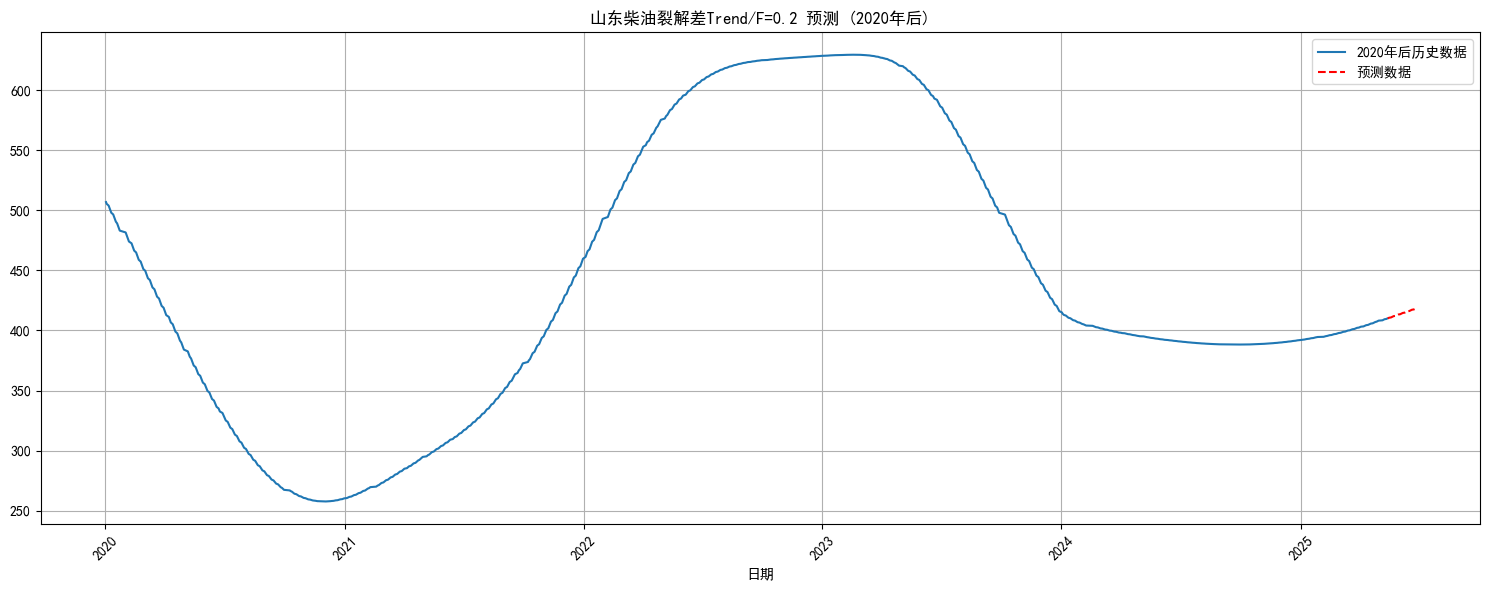

In [7]:

# 获取最后一个日期
last_date = pd.to_datetime(sheet['Date'].iloc[-1])

# 生成未来30个工作日
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=45, freq='D')  # 生成45天以确保获得30个工作日
future_dates = future_dates[future_dates.dayofweek < 5][:30]  # 只保留工作日并取前30天

# 获取最后30个历史值用于线性回归
last_values = sheet['山东柴油裂解差Trend/F=0.2'].tail(30).values
x = np.arange(len(last_values))
y = last_values

# 进行线性回归
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

print(f"当前线性回归系数：斜率 = {z[0]:.6f}, 截距 = {z[1]:.6f}")

# 预测未来30个值
future_x = np.arange(len(last_values), len(last_values) + 30)
future_values = p(future_x)

# 创建预测数据框
future_df = pd.DataFrame({
    'Date': future_dates,
    '山东柴油裂解差Trend/F=0.2': future_values
})

# 合并历史数据和预测数据
sheet_with_predictions = pd.concat([sheet, future_df], ignore_index=True)
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2020-01-01']

# 绘制结果
plt.figure(figsize=(15, 6))
plt.plot(sheet_2020['Date'], sheet_2020['山东柴油裂解差Trend/F=0.2'], label='2020年后历史数据')
plt.plot(future_df['Date'], future_df['山东柴油裂解差Trend/F=0.2'], 'r--', label='预测数据')
plt.title('山东柴油裂解差Trend/F=0.2 预测 (2020年后)')
plt.xlabel('日期')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
########################   读取数据  #########################################
sheet_non_trend = pd.read_excel('eta/山东柴油裂解差Non-Trend—F0.2_合并数据.xlsx', sheet_name='Sheet1')
sheet_non_trend['Date'] = pd.to_datetime(sheet_non_trend['Date'])
# trend + non-trend 
merged_df = pd.merge(
    sheet_non_trend[['Date', '预测值']], 
    future_df[['Date', '山东柴油裂解差Trend/F=0.2']], 
    on='Date',
    how='outer'
)
# 删除包含空值的行
merged_df = merged_df.dropna()
# 计算最终的
merged_df['山东柴油裂解差'] = merged_df['预测值'] + merged_df['山东柴油裂解差Trend/F=0.2']
merged_df.head() 

,Date,预测值,山东柴油裂解差Trend/F=0.2,山东柴油裂解差
605,2025-05-14,319.7683,410.016363,729.784663
606,2025-05-15,318.8870,410.283430,729.170430
607,2025-05-16,314.1422,410.550497,724.692697
608,2025-05-19,295.6244,410.817564,706.441964
609,2025-05-20,296.9009,411.084631,707.985531


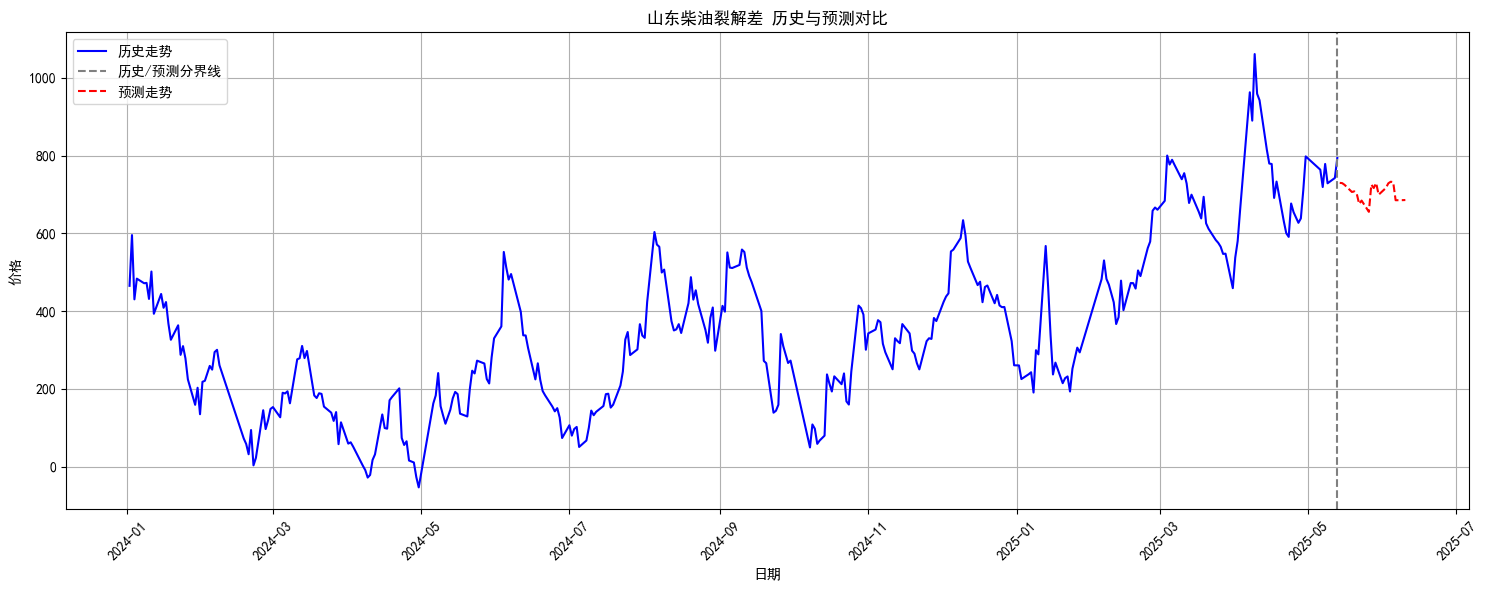

In [9]:
# 绘制最终走势图
plt.figure(figsize=(15, 6))
# 筛选2020年之后的数据
sheet_2020 = sheet[sheet['Date'] >= '2024-01-01']
# 绘制历史数据
plt.plot(sheet_2020['Date'], sheet_2020['山东柴油裂解差'], label='历史走势', color='blue')
# 添加垂直分隔线,标记历史数据和预测数据的分界点
last_historical_date = sheet_2020['Date'].iloc[-1]
plt.axvline(x=last_historical_date, color='gray', linestyle='--', label='历史/预测分界线')
# 绘制预测数据
plt.plot(merged_df['Date'], merged_df['山东柴油裂解差'], label='预测走势', color='red', linestyle='--')

plt.title('山东柴油裂解差 历史与预测对比')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
sheet_data_2023_shizhi = sheet[sheet['Date'].dt.year >= 2023][['Date', '山东柴油裂解差']]
sheet_data_2023_shizhi.columns = ['Date', '实际值']
future_df_shizhi = merged_df[['Date', '山东柴油裂解差']]
merged_df_shizhi = pd.merge(sheet_data_2023_shizhi, future_df_shizhi, on='Date', how='outer')
merged_df_shizhi = merged_df_shizhi.sort_values('Date', ascending=False)
merged_df_shizhi['Date'] = merged_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
merged_df_shizhi.to_excel('eta/山东柴油裂解差_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_shizhi

,Date,实际值,山东柴油裂解差
605,2025/06/10,NaN,685.700935
604,2025/06/09,NaN,685.433868
603,2025/06/06,NaN,685.166801
602,2025/06/05,NaN,731.666334
601,2025/06/04,NaN,732.789167
...,...,...,...
4,2023/01/09,771.0289,NaN
3,2023/01/06,707.9450,NaN
2,2023/01/05,717.9453,NaN
1,2023/01/04,634.5979,NaN


In [11]:
# 将日期列转换为datetime格式
merged_df_shizhi['Date'] = pd.to_datetime(merged_df_shizhi['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_shizhi = merged_df_shizhi.set_index('Date').resample('ME').last()
monthly_df_shizhi = monthly_df_shizhi.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_shizhi = monthly_df_shizhi.reset_index()
monthly_df_shizhi['Date'] = monthly_df_shizhi['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_shizhi.to_excel('eta/山东柴油裂解差_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_shizhi.head()

,Date,实际值,山东柴油裂解差
0,2025/06/30,NaN,685.700935
1,2025/05/31,793.8229,699.257566
2,2025/04/30,797.8931,NaN
3,2025/03/31,459.0120,NaN
4,2025/02/28,660.7536,NaN


---

In [12]:
sheet_data_2023 = sheet[sheet['Date'].dt.year >= 2023][['Date', '山东柴油裂解差Trend/F=0.2']]
sheet_data_2023.columns = ['Date', '实际值']
merged_df_trend = pd.merge(sheet_data_2023, future_df, on='Date', how='outer')
merged_df_trend = merged_df_trend.sort_values('Date', ascending=False)
merged_df_trend['Date'] = merged_df_trend['Date'].dt.strftime('%Y/%m/%d')
merged_df_trend.to_excel('eta/山东柴油裂解差Trend-F=0.2_合并数据.xlsx', index=False,float_format='%.2f')
merged_df_trend

,Date,实际值,山东柴油裂解差Trend/F=0.2
615,2025/06/24,NaN,417.761305
614,2025/06/23,NaN,417.494238
613,2025/06/20,NaN,417.227171
612,2025/06/19,NaN,416.960104
611,2025/06/18,NaN,416.693037
...,...,...,...
4,2023/01/09,628.683773,NaN
3,2023/01/06,628.638902,NaN
2,2023/01/05,628.593417,NaN
1,2023/01/04,628.547359,NaN


In [13]:
# 将日期列转换为datetime格式
merged_df_trend['Date'] = pd.to_datetime(merged_df_trend['Date'])
# 按月份重采样并取每月最后一个交易日的数据
monthly_df_trend = merged_df_trend.set_index('Date').resample('ME').last()
monthly_df_trend = monthly_df_trend.sort_values('Date', ascending=False)
# 重置索引并格式化日期
monthly_df_trend = monthly_df_trend.reset_index()
monthly_df_trend['Date'] = monthly_df_trend['Date'].dt.strftime('%Y/%m/%d')
# 保存月度数据到Excel
monthly_df_trend.to_excel('eta/山东柴油裂解差Trend-F=0.2_月度数据.xlsx', index=False, float_format='%.2f')
monthly_df_trend.head()

,Date,实际值,山东柴油裂解差Trend/F=0.2
0,2025/06/30,NaN,417.761305
1,2025/05/31,409.889336,413.221166
2,2025/04/30,408.144620,NaN
3,2025/03/31,402.383839,NaN
4,2025/02/28,397.844846,NaN


---

In [14]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东柴油裂解差Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "山东柴油裂解差"

# 调用函数更新数据
success = update_excel_data(merged_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东柴油裂解差Trend/F0.2"
# 调用函数更新数据
success = update_excel_data(monthly_df_trend, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "山东柴油裂解差"
# 调用函数更新数据
success = update_excel_data(monthly_df_shizhi, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

已完成：插入/更新数据，并重新计算“方向/偏差率” (protected_date = 2025/05/31)
数据已成功更新到Excel文件
